## Scoring returns

### All imports

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from vol4life.score import sharpe_ratio
import matplotlib.pyplot as plt

### Getting risk-free interest rate ([SELIC](https://dadosabertos.bcb.gov.br/dataset/11-taxa-de-juros---selic))


In [2]:
selic = pd.read_csv("data/bcdata.sgs.11.csv",sep=";")
selic.loc[:,"selic"] = selic.valor.map(lambda s: s.replace(",", ".")).astype("float") / 100
selic.loc[:,"datetime"] = pd.to_datetime(selic.data)
selic = selic[["datetime", "selic"]].groupby("datetime").mean()

### Loading market data and selecting a subset of tickers

In [3]:
path = "data/b3_stocks_1994_2020.csv"
df = pd.read_csv(path)
df.loc[:, "datetime"] =  pd.to_datetime(df.datetime)

tickers = ["PETR3", "VALE3", "BBDC3", "ITSA4"]
initial_date = "2010-01-01"

df_sort = df.set_index(["ticker", "datetime"]).sort_index()
tss = []
for ticker in tickers:  
    ts = df_sort.xs(ticker).close
    ts.name = ticker
    tss.append(ts)

del df_sort
prices = pd.concat(tss,1).interpolate("linear", limit_direction="both")[initial_date:]
returns = prices.pct_change().dropna()

# display
display(HTML("<h3>Price dataset</h3>"))
display(HTML("<br><b>head<b>"))
display(HTML(prices.head(2).to_html()))
display(HTML("<br><b>tail<b>"))
display(HTML(prices.tail(2).to_html()))
display(HTML("<br><b>shape = {}<b>".format(prices.shape)))

,PETR3,VALE3,BBDC3,ITSA4
datetime,,,,
2010-01-04,41.65,51.49,31.00,12.37
2010-01-05,41.40,51.97,30.56,12.33


,PETR3,VALE3,BBDC3,ITSA4
datetime,,,,
2020-04-29,19.00,46.73,18.77,9.26
2020-04-30,18.65,44.86,17.56,9.00


## Scoring Returns:
 - **Return 1**: Uniform weights returns
 - **Return 2**: Returns of a Portfolio concentrated on banks 
 - **Risk-Free-Rate**: SELIC series mean in the period

In [4]:
size = prices.shape[1]
p1 = np.repeat(1 / size, size)
p2 = np.array([0.2, 0.2, 0.3, 0.3])
return1 = prices.dot(p1).pct_change()
return2 = prices.dot(p2).pct_change()

l,r = str(prices.index[0].date()), str(prices.index[-1].date())
rfr = selic[l:r].mean()[0]
uni_sr = sharpe_ratio(return1,rfr=rfr)

print("return1 sr = {:.3f}".format(uni_sr))
print("return2 sr = {:.3f}".format(sharpe_ratio(return2,rfr=rfr)))

return1 sr = -0.270
return2 sr = -0.286


### The Distribution of the Sharpe-Ratio

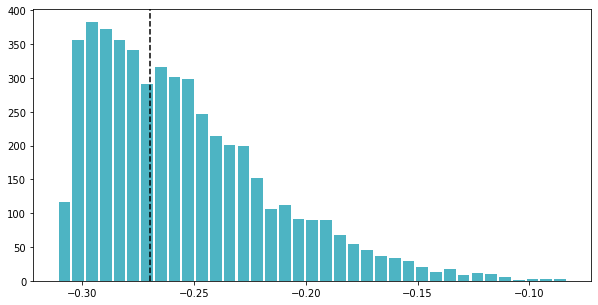

In [5]:
simulations = 5000
sr_series = []

for _ in range(simulations):
    w = np.random.uniform(0,1,size)
    w = w / np.sum(w)
    r = prices.dot(w).pct_change()
    sr = sharpe_ratio(r,rfr=rfr)
    sr_series.append(sr)
    
sr_series = pd.Series(sr_series)

fig, ax = plt.subplots(figsize = (10,5))
n, bins, patches = plt.hist(x=sr_series, bins='auto', color='#0294aa',
                            alpha=0.7, rwidth=0.85)
ax.axvline(uni_sr,0, 140, ls="--", color="k");